In [1]:
from minisom import MiniSom

In [53]:
import pandas as pd
import numpy as np
data = pd.read_csv('diabetes.csv', sep=',', engine='python')
data

Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0              6      148             72             35        0  33.6   
1              1       85             66             29        0  26.6   
2              8      183             64              0        0  23.3   
3              1       89             66             23       94  28.1   
4              0      137             40             35      168  43.1   
..           ...      ...            ...            ...      ...   ...   
763           10      101             76             48      180  32.9   
764            2      122             70             27        0  36.8   
765            5      121             72             23      112  26.2   
766            1      126             60              0        0  30.1   
767            1       93             70             31        0  30.4   

     DiabetesPedigreeFunction  Age  Outcome  
0                       0.627   50        1  
1                       0.351   31        0  
2                       0.672   32        1  
3                       0.167   21        0  
4                       2.288   33        1  
..                        ...  ...      ...  
763                     0.171   63        0  
764                     0.340   27        0  
765                     0.245   30        0  
766                     0.349   47        1  
767                     0.315   23        0  

[768 rows x 9 columns]

In [54]:
target = data['Outcome'].values
label_names = {0:'non', 1:'oui'}
data = data[data.columns[:-1]]
# data normalization
data = (data - np.mean(data, axis=0)) / np.std(data, axis=0)
data = data.values
data

array([[ 0.63994726,  0.84832379,  0.14964075, ...,  0.20401277,
         0.46849198,  1.4259954 ],
       [-0.84488505, -1.12339636, -0.16054575, ..., -0.68442195,
        -0.36506078, -0.19067191],
       [ 1.23388019,  1.94372388, -0.26394125, ..., -1.10325546,
         0.60439732, -0.10558415],
       ...,
       [ 0.3429808 ,  0.00330087,  0.14964075, ..., -0.73518964,
        -0.68519336, -0.27575966],
       [-0.84488505,  0.1597866 , -0.47073225, ..., -0.24020459,
        -0.37110101,  1.17073215],
       [-0.84488505, -0.8730192 ,  0.04624525, ..., -0.20212881,
        -0.47378505, -0.87137393]])

In [92]:
# # Initialization and training
# size = 15
# som = MiniSom(size, size, data.shape[1], sigma=2, learning_rate=.5, 
#               neighborhood_function='gaussian', random_seed=1)

# som.pca_weights_init(data)
# som.train(data, 1000, verbose=True)  # random training
size = 15
som = MiniSom(size, size, len(data[0]), neighborhood_function='gaussian', sigma=2, random_seed=1)

som.pca_weights_init(data)
som.train_random(data, 1000, verbose=True)

 [ 1000 / 1000 ] 100% - 0:00:00 left 
 quantization error: 1.2038670722998424


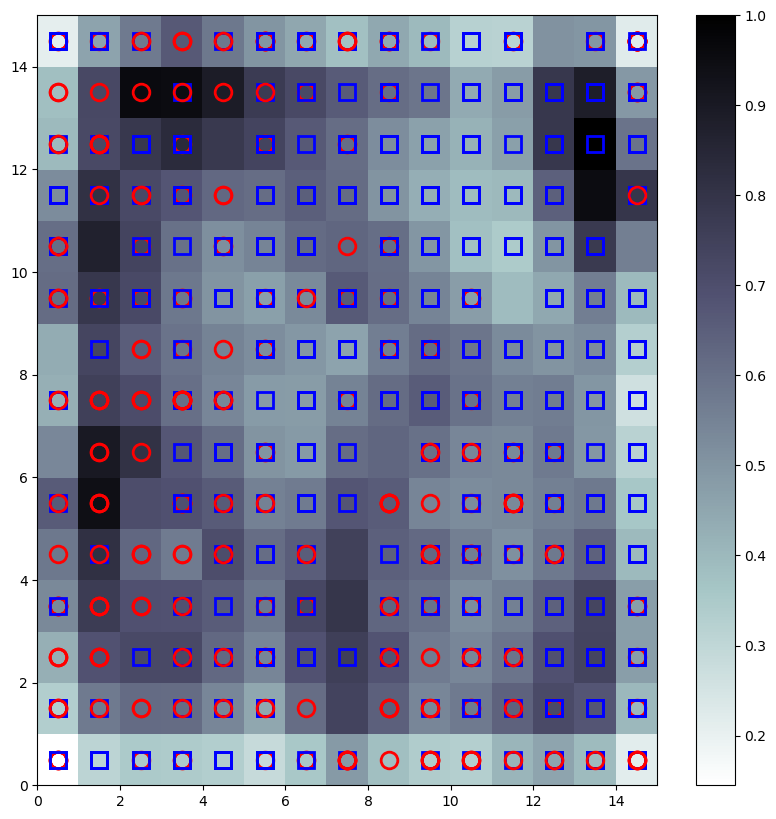

In [93]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(10, 10))

plt.pcolor(som.distance_map().T, cmap='bone_r')  # plotting the distance map as background
plt.colorbar()

# Plotting the response for each pattern in the iris dataset
# different colors and markers for each label
markers = ['o', 's']
colors = ['r', 'b']
for cnt, xx in enumerate(data):
    w = som.winner(xx)  # getting the winner
    # palce a marker on the winning position for the sample xx
    plt.plot(w[0]+.5, w[1]+.5, markers[target[cnt]-1], markerfacecolor='None',
             markeredgecolor=colors[target[cnt]-1], markersize=12, markeredgewidth=2)

plt.show()

# Plus c'est foncé, plus j'ai peu d'informations

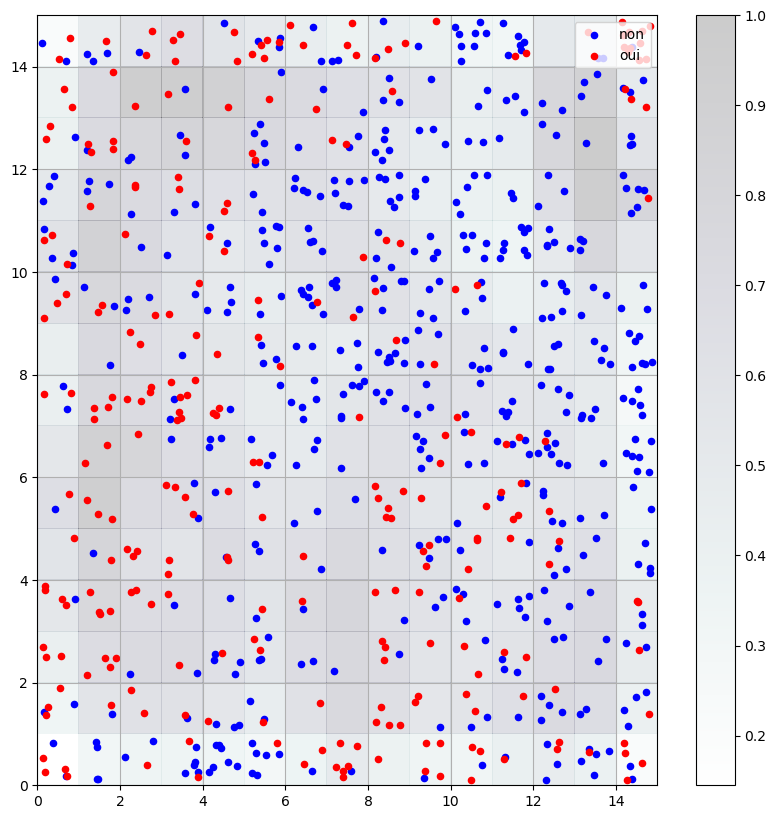

In [94]:
w_x, w_y = zip(*[som.winner(d) for d in data])
w_x = np.array(w_x)
w_y = np.array(w_y)

plt.figure(figsize=(10, 10))
plt.pcolor(som.distance_map().T, cmap='bone_r', alpha=.2)
plt.colorbar()

for c in np.unique(target):
    idx_target = target==c
    plt.scatter(w_x[idx_target]+.5+(np.random.rand(np.sum(idx_target))-.5)*.8,
                w_y[idx_target]+.5+(np.random.rand(np.sum(idx_target))-.5)*.8,
                s=20, c=colors[c-1], label=label_names[c])
plt.legend(loc='upper right')
plt.grid()
# plt.savefig('resulting_images/som_seed.png')
plt.show()

# On voit les individus qui sont représentés avec les tâches foncés plus haut (avec explication de l'espace)

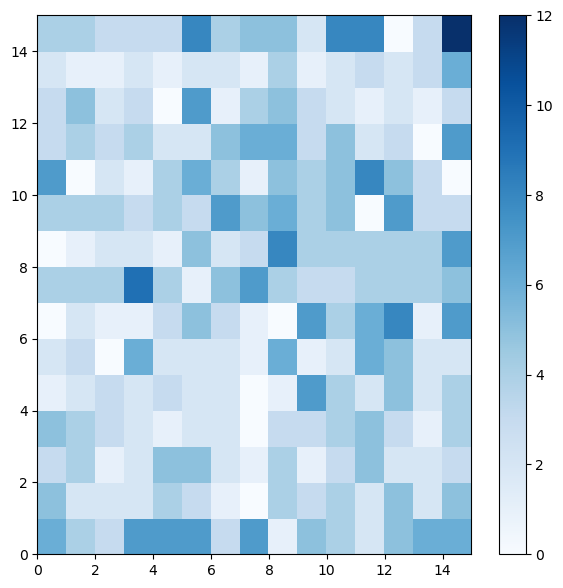

In [95]:
plt.figure(figsize=(7, 7))
frequencies = som.activation_response(data)
plt.pcolor(frequencies.T, cmap='Blues') 
plt.colorbar()
plt.show()

# Neuronnes actives (plus c'est bleue, plus c'est concentré en neuronnes)
# à mettre en sperspectives avec celles avec le carré plus haut genre en haut à droite

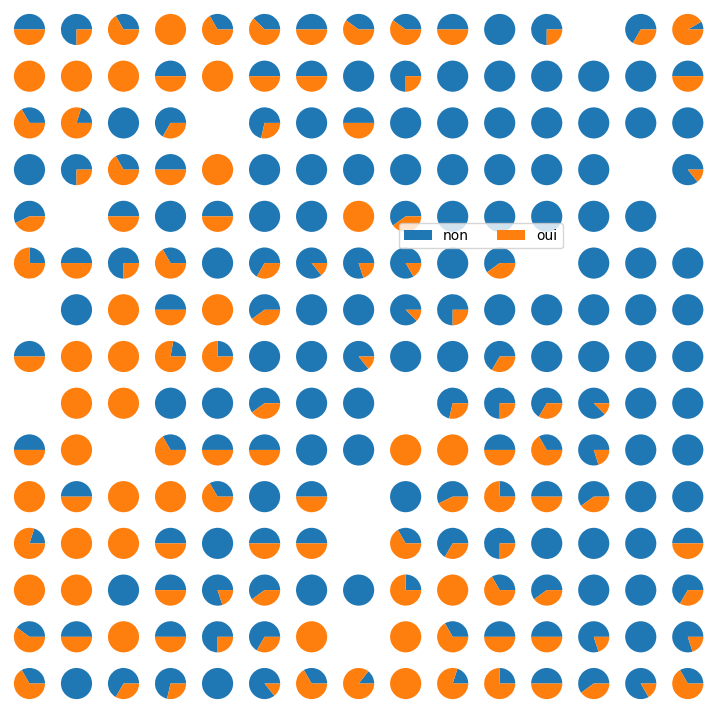

In [96]:
import matplotlib.gridspec as gridspec

labels_map = som.labels_map(data, [label_names[t] for t in target])

fig = plt.figure(figsize=(9, 9))
the_grid = gridspec.GridSpec(n_neurons, m_neurons, fig)
for position in labels_map.keys():
    label_fracs = [labels_map[position][l] for l in label_names.values()]
    plt.subplot(the_grid[n_neurons-1-position[1],
                         position[0]], aspect=1)
    patches, texts = plt.pie(label_fracs)

plt.legend(patches, label_names.values(), bbox_to_anchor=(3.5, 6.5), ncol=3)
# plt.savefig('resulting_images/som_seed_pies.png')
plt.show()

# Quand c'est vide, pas d'informations / pas de clusters, beaucoup de oui (répartition oui)

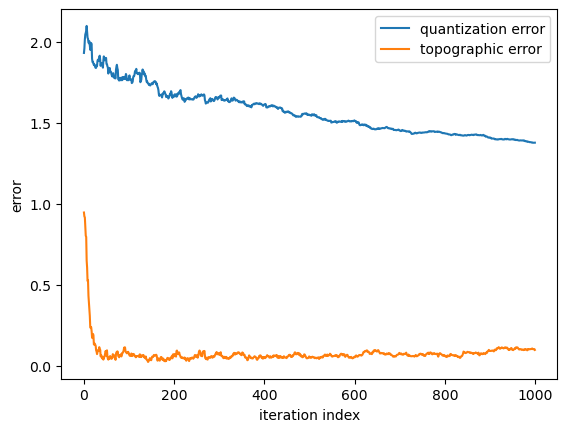

In [97]:
som = MiniSom(10, 20, data.shape[1], sigma=3., learning_rate=.7,
              neighborhood_function='gaussian', random_seed=10)

max_iter = 1000
q_error = []
t_error = []

for i in range(max_iter):
    rand_i = np.random.randint(len(data))
    som.update(data[rand_i], som.winner(data[rand_i]), i, max_iter)
    q_error.append(som.quantization_error(data))
    t_error.append(som.topographic_error(data))

plt.plot(np.arange(max_iter), q_error, label='quantization error')
plt.plot(np.arange(max_iter), t_error, label='topographic error')
plt.ylabel('error')
plt.xlabel('iteration index')
plt.legend()
plt.show()

# Quantification error c'est la même chose
# Topographic c'est le surentrainement